# Import

In [1]:
# importing
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(18, 6) )

# Function for determining the impulse response of an RC filter

In [2]:
########################
# find impulse response of an RC filter
########################
def get_rc_ir(K, n_up, t_symbol, r):
    
    ''' 
    Determines coefficients of an RC filter 
    
    Formula out of: K.-D. Kammeyer, Nachrichtenübertragung
    At poles, l'Hospital was used 
    
    NOTE: Length of the IR has to be an odd number
    
    IN: length of IR, upsampling factor, symbol time, roll-off factor
    OUT: filter coefficients
    '''

    # check that IR length is odd
    assert K % 2 == 1, 'Length of the impulse response should be an odd number'
    
    # map zero beta to close-to-zero
    if r == 0:
        r = 1e-32


    # initialize output length and sample time
    rc = np.zeros( K )
    t_sample = t_symbol / n_up
    
    
    # time indices and sampled time
    k_steps = np.arange( -(K-1) / 2.0, (K-1) / 2.0 + 1 )   
    t_steps = k_steps * t_sample
    
    for k in k_steps.astype(int):
        
        if t_steps[k] == 0:
            rc[ k ] = 1.
            
        elif np.abs( t_steps[k] ) == t_symbol / ( 2.0 * r ):
            rc[ k ] = r * np.sin( np.pi / r )
            
        else:
            rc[ k ] = np.sin( np.pi * t_steps[k]/t_symbol ) / np.pi / t_steps[k] \
                * np.cos( r * np.pi * t_steps[k] / t_symbol ) \
                / ( 1.0 - ( 2.0 * r * t_steps[k] / t_symbol )**2 )
 
    return rc

# Parameters

In [3]:
# constellation points of modulation
M = 4
constellation_points = [ np.exp( 1j * 2 * np.pi * m / M + 1j * np.pi / M ) for m in range( M ) ]


# symbol time and number of symbols    
t_symb = 1.0 
n_symb = 100

# Get QPSK and OQPSK signal

In [4]:
# get filter impulse response
r = 0.33
n_up = 16            # samples per symbol
syms_per_filt = 4  # symbols per filter (plus-minus in both directions)        
K_filt = 2 * syms_per_filt * n_up + 1         # length of the fir filter


# generate random vector and modulate the specified modulation scheme
data = np.random.randint( M, size = n_symb )
s = [ constellation_points[ d ] for d in data ]


# prepare sequence to be filtered
s_up = np.zeros( n_symb * n_up, dtype=complex )        
s_up[ : : n_up ] = s


# get RC pulse 
rc = get_rc_ir( n_up * syms_per_filt * 2 + 1, n_up, t_symb, r )
rc /= np.linalg.norm( rc ) 


# pulse-shaping
s_rc = np.convolve( rc, s_up )
   
# extracting real and imaginary part    
s_rc_I = np.real( s_rc )
s_rc_Q = np.imag( s_rc )


# generating OQPSK by relatively shifting I and Q component
s_oqpsk = s_rc_I[ : - n_up//2 ] + 1j * s_rc_Q[ n_up//2 : ]    

# Plotting

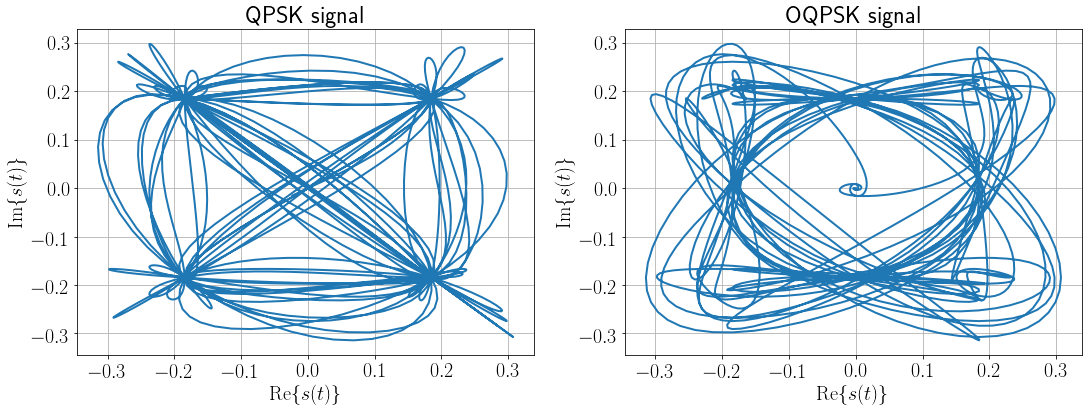

In [5]:
# plotting    
plt.subplot(121)
plt.plot( np.real( s_rc ), np.imag( s_rc ), linewidth=2.0 )  

plt.grid( True )
plt.xlabel( '$\mathrm{Re}\\{s(t)\\}$' ) 
plt.ylabel(' $\mathrm{Im}\\{s(t)\\}$' ) 
plt.title( 'QPSK signal' )

plt.subplot(122)
plt.plot( np.real( s_oqpsk ), np.imag( s_oqpsk ), linewidth=2.0 )  

plt.grid( True )
plt.xlabel( '$\mathrm{Re}\\{s(t)\\}$' ) 
plt.ylabel(' $\mathrm{Im}\\{s(t)\\}$' ) 
plt.title( 'OQPSK signal' )